In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
sns.set_style('white')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from LB_D2Q9.dimensionless import opencl_dim as lb_cl
from LB_D2Q9.dimensionless import cython_dim as lb_cython
from LB_D2Q9.dimensionless import python_dim as lb_python

We now want to visualize the evolution of the flow...let's see how it goes...

In [7]:
from IPython import display

# Obtaining MLUPS: Million Lattice Updates per Second

It's probably easier to specify dt and dr and the dimensions. Then get everything else from that...yeah. That way the velocity is on the scale of U ~ 0.1 or so.

In [8]:
N = 125 # Number of grid points covering characteristic length scale

D = 1. # meter
rho = 1. # kg/m^3
nu = 1. # Viscosity, m^2/s

pressure_grad = -10 # Pa/m

pipe_length = 3*D # meter

# initialize cylinder
cylinder_center = [pipe_length/4, D/2]
cylinder_radius = D/10

sim_cl = lb_cl.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                             N=N, time_prefactor=1.,
                             cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                             two_d_local_size = (32, 32), three_d_local_size = (32, 32, 1))

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
omega 0.413223140496
2d global: (3776, 1280)
2d local: (32, 32)
3d global: (3776, 1280, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.23
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024, 1024, 64]
---------------------------
This context is associated with  1 devices
inlet rho: 1.00368738304
outlet rho: 1.0


In [9]:
sim_cython = lb_cython.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                                          cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                                          N=N, time_prefactor=1.)

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
omega 0.413223140496
inlet rho: 1.00368738304
outlet rho: 1.0


In [10]:
sim_python = lb_python.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                                          cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                                          N=N, time_prefactor=1.)

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
omega 0.413223140496
inlet rho: 1.00368738304
outlet rho: 1.0


In [11]:
total_lattice_size = sim_cl.nx*sim_cl.ny
print 'Lattice size is ' , '%.3e' % total_lattice_size

Lattice size is  4.693e+06


In [13]:
import time

## OpenCL

In [14]:
num_steps = 1000

start_time = time.time()
sim_cl.run(num_steps)
end_time = time.time()

time_elapsed = end_time - start_time
print 'Iterations completed:' , num_steps
print 'Time elapsed (s): ', time_elapsed 
opencl_MLUPS = (num_steps*(total_lattice_size/10.**6.))/time_elapsed
print 'MLUPS:' , opencl_MLUPS

Iterations completed: 1000
Time elapsed (s):  14.4432220459
MLUPS: 324.892948754


Ok, so we get 325 million lattice updtates per second! That is not bad! We can speed this up too by further optimizing our kernels.

In [132]:
%%prun 

sim_cl.run(num_steps)

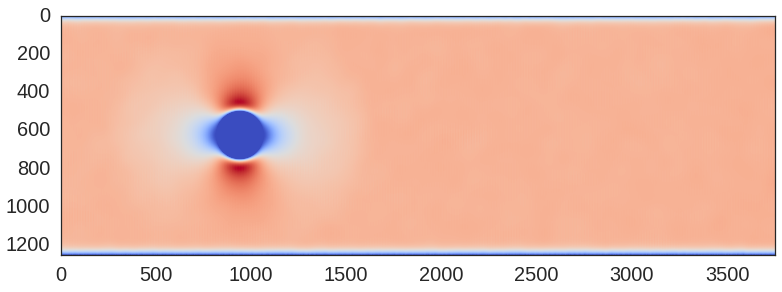

In [15]:
fields_cl = sim_cl.get_nondim_fields()
plt.imshow(fields_cl['u'].T, cmap=cm.coolwarm)

## Cython

In [16]:
num_steps = 20

start_time = time.time()
sim_cython.run(num_steps)
end_time = time.time()

time_elapsed = end_time - start_time
print 'Iterations completed:' , num_steps
print 'Time elapsed (s): ', time_elapsed 
cython_MLUPS = (num_steps*(total_lattice_size/10.**6.))/time_elapsed
print 'MLUPS:' , cython_MLUPS

Iterations completed: 20
Time elapsed (s):  15.8282828331
MLUPS: 5.92926099373


In [133]:
num_steps = 20

In [134]:
%%prun

sim_cython.run(num_steps)

The plot will be significantly less developed, i.e. the pipe just turning on, as we completed far less iterations. There will likely be large fluctuations.

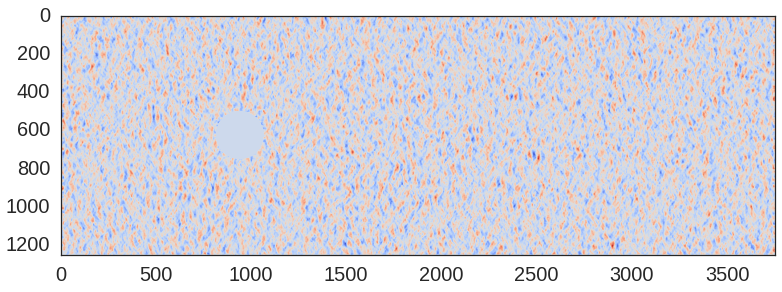

In [17]:
plt.imshow(sim_cython.u.T, cmap=cm.coolwarm)
plt.grid(False)

## Python

In [18]:
num_steps = 3

start_time = time.time()
sim_python.run(num_steps)
end_time = time.time()

time_elapsed = end_time - start_time
print 'Iterations completed:' , num_steps
print 'Time elapsed (s): ', time_elapsed 
python_MLUPS = (num_steps*(total_lattice_size/10.**6.))/time_elapsed
print 'MLUPS:' , (num_steps*(total_lattice_size/10.**6.))/time_elapsed

Iterations completed: 3
Time elapsed (s):  28.1816470623
MLUPS: 0.499527333121


In [136]:
%%prun

sim_python.run(num_steps)

The flow field will be even less developed here. We could only run about 3 iterations in 30 seconds.

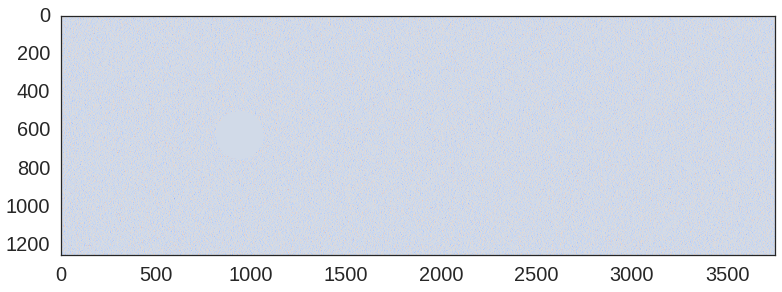

In [19]:
plt.imshow(sim_python.u.T, cmap=cm.coolwarm)
plt.grid(False)

# Plotting Implementation Speedup

It is clear that we acheived some incredible speedups. Let's make a plot illustrating this.

In [83]:
sns.set_style('ticks')
import matplotlib
matplotlib.rc('text', usetex=True)

In [84]:
import pandas as pd

In [85]:
data_list = []
columns = ['Implementation', 'MLUPS']
data_list.append(['Python', python_MLUPS])
data_list.append(['Cython', cython_MLUPS])
data_list.append(['OpenCL', opencl_MLUPS])

speedup_df = pd.DataFrame(data=data_list, columns=columns)

In [86]:
speedup_df

,Implementation,MLUPS
0,Python,0.499527
1,Cython,5.929261
2,OpenCL,324.892949


In [87]:
speedup_df['speedup'] = speedup_df['MLUPS']/np.min(speedup_df['MLUPS'])

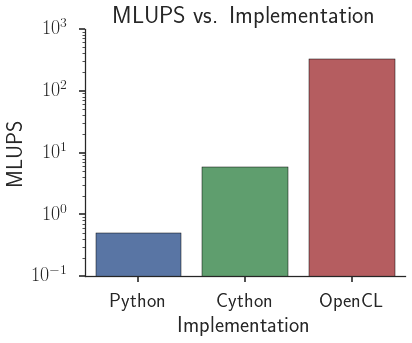

In [126]:
sns.factorplot(data=speedup_df, x='Implementation', y='MLUPS', kind='bar')
plt.gca().set_yscale('log')
plt.title('MLUPS vs. Implementation')
plt.gcf().set_size_inches(6.5, 5)

plt.savefig('mlups_vs_implementation.png', dpi=200, bbox_inches='tight')
plt.savefig('mlups_vs_implementation.eps', dpi=200, format='eps', bbox_inches='tight')

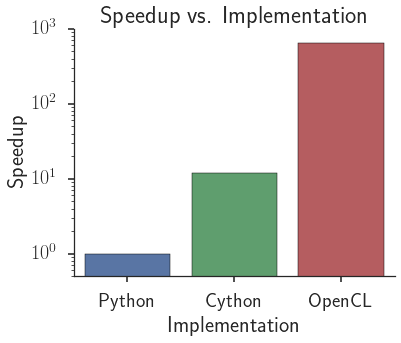

In [127]:
sns.factorplot(data=speedup_df, x='Implementation', y='speedup', kind='bar')
plt.ylabel('Speedup')
plt.gca().set_yscale('log')
plt.ylim(.5, 10.**3.)
plt.title('Speedup vs. Implementation')

plt.gcf().set_size_inches(6.5, 5)

plt.savefig('speedup_vs_implementation.png', dpi=200, bbox_inches='tight')
plt.savefig('speedup_vs_implementation.eps', dpi=200, format='eps', bbox_inches='tight')